In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp, cumulative_trapezoid
from zoopt import Dimension, Parameter, Objective, Opt


from CBF import *
from Nonlinear_System import *

## System

$$
\begin{pmatrix}
\dot{x}_1 \\
\dot{x}_2 \\
\dot{x}_3 \\
\dot{x}_4
\end{pmatrix} 
= 
\begin{pmatrix}
x_4 \cos (x_3) \\
x_4 \sin(x_3) \\
0 \\
0
\end{pmatrix}
+
\begin{pmatrix}
0 & 0\\
0 & 0\\
1 & 0\\
0 & 1
\end{pmatrix}
\begin{pmatrix}
u_1 \\
u_2
\end{pmatrix}
$$

In [2]:
def f(x):
    return np.array([x[3]*np.cos(x[2]), x[3]*np.sin(x[2]), 0, 0])

def g(x):
    return np.array([[0, 0],[0, 0], [1, 0],[0, 1]])

unicycle = ControlAffine(f, g, n=4, m=2)

a = 5

# Higher Order CBF for lane keeping
def h(x):
    return -2*x[1]*x[3]*np.sin(x[2]) + a*(1-x[1]*x[1])

def dh(x):
    return np.array([0, -2*x[3]*np.sin(x[2])-2*a*x[1], -2*x[1]*x[3]*np.cos(x[2]), -2*x[1]*np.sin(x[2])])

x0 = np.array([0, 0, 0.1, 0.1]) # Initial State

In [3]:
# Amplitude and Frequency of reference trajectory
A = 1.5
w = 1

# Reference Trajectory and derivatives
def y_des(t):
    return A*np.sin(w*t)

def y_dot_des(t):
    return A*w*np.cos(w*t)

def y_ddot_des(t):
    return -A*w*w*np.sin(w*t)

def x_des(t):
    return t

def x_dot_des(t):
    return 1

def x_ddot_des(t):
    return 0

# Tracking Controller - Feedback Linearization
def ctrl(x, t):
    k1 = 4
    k2 = 4      # Tracking Gains (NOT related to R-CBF)
    v1 = -k1*(x[0]-x_des(t)) - k2*(x[3]*np.cos(x[2]) - x_dot_des(t)) + x_ddot_des(t)
    v2 = -k1*(x[1]-y_des(t)) - k2*(x[3]*np.sin(x[2]) - y_dot_des(t)) + y_ddot_des(t)
    V = np.hstack([v1, v2])
    Tf = np.array([[-x[3]*np.sin(x[2]), np.cos(x[2])],[x[3]*np.cos(x[2]), np.sin(x[2])]])
    return np.linalg.inv(Tf)@V


# Time varying bound for uncertainty
def delta(x, t):
    return np.array([0.2 + 0.2*np.sin(0.01*t), 0.2 + 0.2*np.sin(0.01*t), 0.2 + 0.2*np.sin(0.01*t), 0.2 + 0.2*np.sin(0.01*t)])

# "Estimation" function to corrupt state estimate 
# while respecting uncertainty bound from delta(x,t)
def est(x_true, t):
    return x_true - np.tanh(x_true)*delta(x_true, t)

In [4]:
alpha = 2   # Constant class K function in CBF
k1 = 2
k2 = 2      # R-CBF gains (irrelavant, values will be calculated in runtime)

rob_cbf = Rob_CBF(alpha, h, dh, unicycle, k1, k2)       # True CBF used as safety filter
rob_cbf_sigma = Rob_CBF(alpha, h, dh, unicycle, k1, k2) # copy of CBF used in optimizing over values of k1, k2

In [5]:
# Time parameters for Simulation
t_end = 10          # Total Simulation Time
sample_dt = 0.1     # Sampling time for controller implementation
dt = 1e-2           # Integrator step size

n_steps = int(t_end/dt)
n_steps_sample = int(sample_dt/dt)
n_samples = int(t_end/sample_dt)

t = np.round(np.linspace(0, t_end, n_steps+1), 3)
t_samples = np.round(np.linspace(0, t_end, n_samples+1)[:-1], 3)

x_state = np.zeros((4, len(t)))
x_state[:, 0] = x0

### Derivative Free Optimization Functions

In [6]:
N_samples = 20      # Number of points to sample around current state estimate

def sigma(xhat, kdes, d, k1, k2):
    """
    Estimates the max difference of the minimally invasive controller 
    around current point

    sigma( ) = max ||k(x) - k(x_hat)||  

    where max is over a sampled set of x in a ball of radius delta around x_hat
    """
    rob_cbf_sigma.k1 = k1
    rob_cbf_sigma.k2 = k2
    k = lambda x: rob_cbf_sigma.filter(x, kdes)
    x_tildes = np.random.uniform(low=-d, high=d, size=(N_samples, 4)) + xhat
    return np.max(np.abs(np.array([k(x_tilde) for x_tilde in x_tildes]) - k(xhat)))

In [7]:
def get_ks(xhat, d, kdes):      # Refer ZOOpt Documentation
    """
    Calculates k1, k2 that minimizes the inflation of the safe set
    """
    def cost_func(sol):
        k1, k2 = sol.get_x()
        return max(sigma(xhat, kdes, d, k1, k2)-k1, 0)/(2*k2) + 0.1*k1 + 0.1*k2    
    
    dim = Dimension(size=2, regs=[[0, 2], [0, 2]], tys=[True, True]) 
    objective = Objective(func=cost_func, dim=dim)
    param = Parameter(budget=200)
    solution = Opt.min(objective, param)
    # print("Minimum value:", solution.get_value())
    return solution.get_x()

## Simulation Loop

In [8]:
x_samples = []
u_samples = []
k1_samples = []
k2_samples = []

# Simulation Loop performs ZOH control input between samples

for i,t_sample in enumerate(t_samples):
    idx = i*n_steps_sample  # Final idx from previous sample
    
    x_true = x_state[:, idx]
    x_hat = est(x_true, t_sample)     # Measure state
    d = delta(x_true, t_sample)       # Error bound on state
    
    # u_des = ctrl(x_hat, t_sample)  # Compute control input using estimate
    u_des = ctrl(x_true, t_sample)   # Compute control input using true state

    k1, k2 = get_ks(x_hat, d, u_des)      # Compute k1, k2 using ZOOpt
    # k1, k2 = 2, 2                       # Constant k1, k2
    
    rob_cbf.k1 = k1
    rob_cbf.k2 = k2

    # u_safe = rob_cbf.filter(x_true, u_des)  # CBF filter with true state
    u_safe = rob_cbf.filter(x_hat, u_des)  # CBF filter with estimate state
    # u_safe = u_des  # Bypass Safety Filter

    t_sample_end = np.round(t_sample+sample_dt, 3)  # prevents "out of range" errors due to numerical errors
    x_state[:, idx+1: idx+n_steps_sample+1] = solve_ivp(lambda t, y: unicycle.RHS(y, u_safe), (t_sample, t_sample_end),
                                                         x_true, t_eval=t[idx+1: idx+n_steps_sample+1]).y
    
    # Save Values in List
    x_samples.append(x_true)
    k1_samples.append(k1)
    k2_samples.append(k2)
    u_samples.append(u_safe)

# Convert Lists to np arrays
x_samples = np.array(x_samples)
u_samples = np.array(u_samples)
k1_samples = np.array(k1_samples)
k2_samples = np.array(k2_samples)

[zoopt] x: [0.011120506388853566, 3.4167897768996e-10]
[zoopt] value: 0.0011120506730532542
[zoopt] x: [3.391030193272606e-10, 6.076840018064359e-09]
[zoopt] value: 6.41594303739162e-10
[zoopt] x: [2.3958385429439254e-08, 3.160060940649485e-10]
[zoopt] value: 2.4274391523504203e-09
[zoopt] x: [2.0888365140419916e-08, 9.224254142190128e-08]
[zoopt] value: 1.1313090656232121e-08
[zoopt] x: [7.076325282464091e-08, 2.0846812775293622e-05]
[zoopt] value: 2.0917576028118266e-06
[zoopt] x: [0.012863723751788481, 0.42691139667810474]
[zoopt] value: 0.043977512042989324
[zoopt] x: [1.874626991696383, 1.2611207426189015]
[zoopt] value: np.float64(0.3160258297147025)
[zoopt] x: [1.5736811343649082, 0.3831456384205338]
[zoopt] value: np.float64(0.4136173416127899)
[zoopt] x: [1.581869700011585, 0.15041984306317469]
[zoopt] value: np.float64(0.40742811554713804)
[zoopt] x: [1.617069992136256, 1.794468806617125]
[zoopt] value: np.float64(0.5807479270854649)
[zoopt] x: [1.1973033614606807, 1.31873023

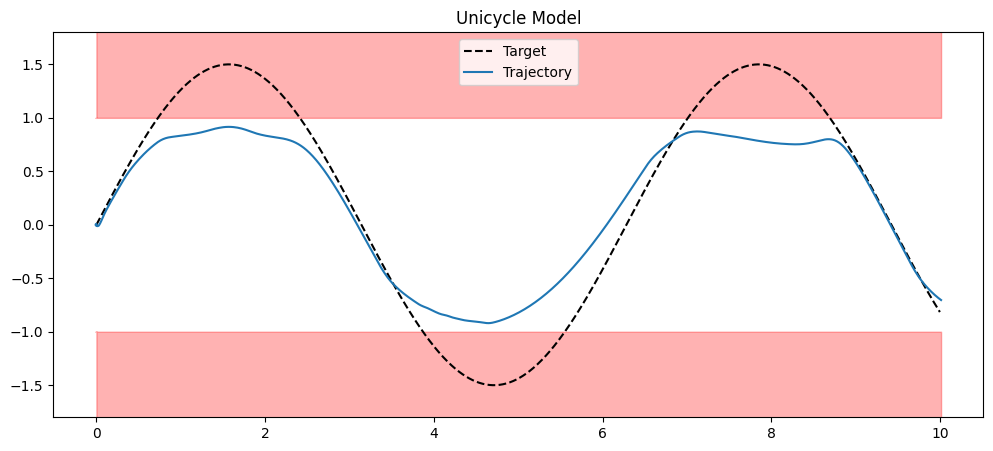

In [9]:
plt.figure(figsize=(12, 5))
plt.title("Unicycle Model")
plt.plot(x_des(t), y_des(t), color="black", label="Target", ls="--")
plt.plot(x_state[0,:], x_state[1,:], label="Trajectory")
# plt.scatter(x_samples[:, 0], x_samples[:, 1])
plt.fill_between(x_state[0], x_state[0]*0 + 1, x_state[0]*0 + 4, color="red", alpha=0.3)
plt.fill_between(x_state[0], x_state[0]*0 - 1, x_state[0]*0 - 4, color="red", alpha=0.3)
plt.ylim([-1.8, 1.8])
plt.legend()
plt.show()

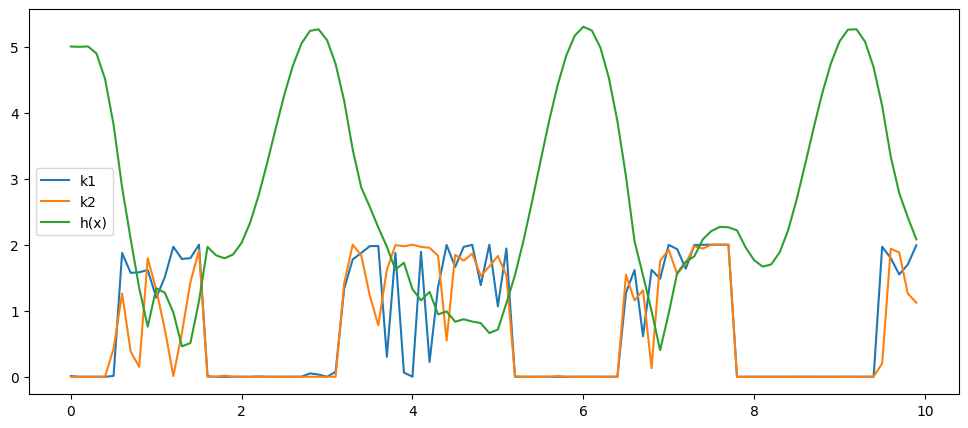

In [10]:
plt.figure(figsize=(12, 5))
plt.plot(t_samples, k1_samples, label="k1")
plt.plot(t_samples, k2_samples, label="k2")
plt.plot(t_samples, h(x_samples.T), label="h(x)")
plt.legend()
plt.show()